:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`Display.ipynb`**!

:::

(display-nb)=
# Display and animate functions

`plenoptic` contains a variety of code for visualizing the outputs and the process of synthesis. This notebook details how to make use of that code, which has largely been written with the following goals:
1. If you follow the [model API](models-doc) (and that of {class}`Synthesis <plenoptic.synthesize.synthesis.Synthesis>` or {class}`OptimizedSynthesis <plenoptic.synthesize.synthesis.OptimizedSynthesis>`, if creating a new synthesis method; see the [synthesis design description](synthesis-objects)), display code should plot something reasonably useful automatically.
2. The code is flexible enough to allow for customization for more useful visualizations.
3. If the plotting code works, the animate code should also.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import plenoptic as po

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72
# Animation-related settings
plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.dpi"] = 72

## General

We include two wrappers of display code from [pyrtools](inv:pyrtools:std:doc#index), adapting them for use with tensors. These {func}`imshow <plenoptic.tools.display.imshow>` and {func}`animshow <plenoptic.tools.display.animshow>` functions, which accept tensors of real- or complex-valued images or videos (respectively) and properly convert them to arrays for display purposes. These are not the most flexible functions (for example, {func}`imshow <plenoptic.tools.display.imshow>` requires that real-valued tensors be 4d) but, assuming you follow our API, should work relatively painlessly. The main reason for using them is that we guarantee fidelity to image size: a value in the tensor corresponds to a pixel or an integer number of pixels in the image (if upsampling); if downsampling, we can only down-sample by factors of two. This way, you can be sure that any strange appearance of the image is not due to aliasing in the plotting.

For {func}`imshow <plenoptic.tools.display.imshow>`, we require that real-valued tensors be 4d: `(batch, channel, height, width)`. If you're showing images, they're likely to be grayscale (in which case there's only 1 channel) or RGB(A) (in which case there's 3 or 4, depending on whether it includes the alpha channel). We plot grayscale images without a problem:

torch.Size([2, 1, 256, 256])


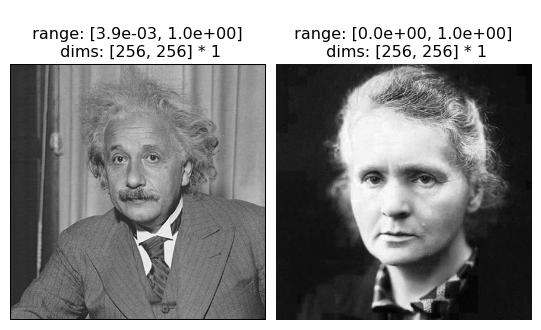

In [3]:
img = torch.cat([po.data.einstein(), po.data.curie()], axis=0)
print(img.shape)
fig = po.imshow(img);

We need to tell {func}`imshow <plenoptic.tools.display.imshow>` that the image(s) are RGB in order for it to be plot correctly.

torch.Size([2, 3, 256, 256])


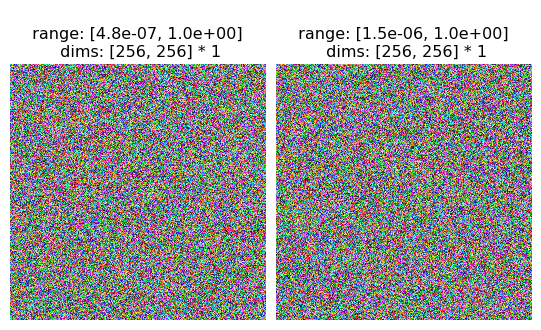

In [4]:
rgb = torch.rand(2, 3, 256, 256)
print(rgb.shape)
fig = po.imshow(rgb, as_rgb=True);

 This is because we don't want to assume that a tensor with 3 or 4 channels is always RGB. To pick a somewhat-contrived example, imagine the following steerable pyramid:

In [5]:
pyr = po.simul.SteerablePyramidFreq(img.shape[-2:], downsample=False, height=1, order=2)

In [6]:
coeffs, _ = pyr.convert_pyr_to_tensor(pyr(img), split_complex=False)

print(coeffs.shape)

torch.Size([2, 5, 256, 256])


The first and last channels are residuals, so if we only wanted to look at the coefficients, we'd do the following:

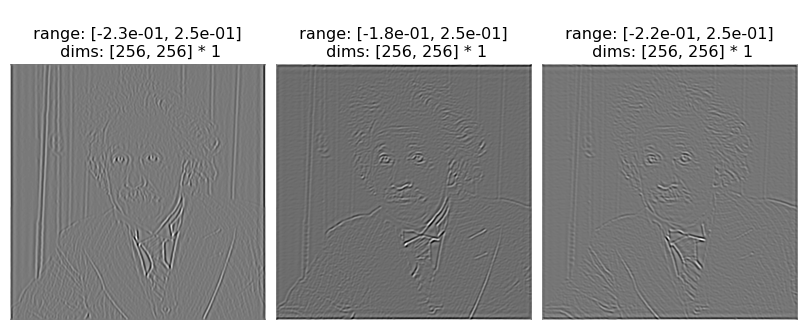

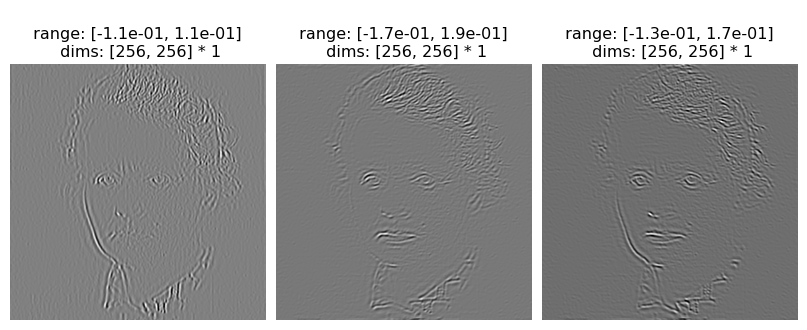

In [7]:
po.imshow(coeffs[:, 1:-1], batch_idx=0)
po.imshow(coeffs[:, 1:-1], batch_idx=1);

We really don't want to interpret those values as RGB.

Note that in the above {func}`imshow <plenoptic.tools.display.imshow>` calls, we had to specify the `batch_idx`. This function expects a 4d tensor, but if it has more than one channel and more than one batch (and it's not RGB), we can't display everything. The user must therefore specify either `batch_idx` or `channel_idx`.

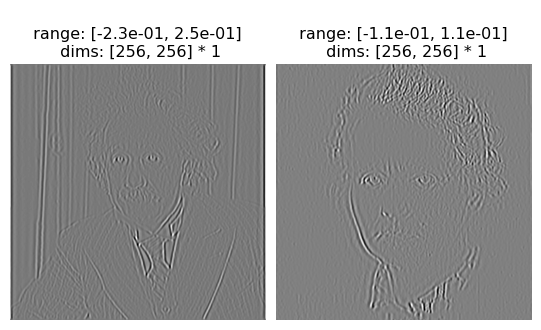

In [8]:
po.imshow(coeffs[:, 1:-1], channel_idx=0);

{func}`animshow <plenoptic.tools.display.animshow>` works analogously to {func}`imshow <plenoptic.tools.display.imshow>`, but expecting a 5d tensor: `(batch, channel, time, height, width)`. It returns a `matplotlib.animation.FuncAnimation` object, which can be saved as an mp4 or converted to an html object for display in a Jupyter notebook (because of the matplotlib configuration options set in the first cell of this notebook, and others in our documentation that make use of them, this happens automatically).

In [9]:
pyr = po.simul.SteerablePyramidFreq(
    img.shape[-2:],
    downsample=False,
    height="auto",
    order=3,
    is_complex=True,
    tight_frame=False,
)
coeffs, _ = pyr.convert_pyr_to_tensor(pyr(img), split_complex=False)
print(coeffs.shape)
# because coeffs is 4d, we add a dummy dimension for the channel in order to make
# animshow happy
po.animshow(coeffs.unsqueeze(1), batch_idx=0, vrange="indep1")

torch.Size([2, 26, 256, 256])


## Synthesis-specific

Each synthesis method has a variety of display code to visualize the state and progress of synthesis, as well as to ease understanding of the process and look for ways to improve. For example, in metamer synthesis, it can be useful to determine what component of the model has the largest error.

In [10]:
img = po.data.einstein().to(DEVICE)
model = po.simul.OnOff((7, 7)).to(DEVICE)
model.eval()
rep = model(img)

As long as your model returns a 3d or 4d vector (first two dimensions corresponding to `batch` and `channel`), then our plotting code should work automatically. If it returns a 3d representation, we plot a stem plot; if it's 4d, an image.

[<Axes: title={'center': '_00\n range: [-7.3e-01, 7.3e-01] \n dims: [256, 256] * 1.0'}>,
 <Axes: title={'center': '_01\n range: [-7.2e-01, 7.2e-01] \n dims: [256, 256] * 1.0'}>]

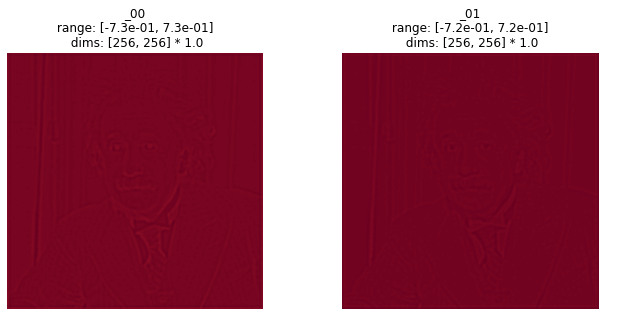

In [11]:
po.tools.display.plot_representation(data=rep, figsize=(11, 5))

This also gets used in the plotting code built into our synthesis methods.

In [12]:
po.tools.remove_grad(model)
met = po.synth.Metamer(img, model)
met.synthesize(
    max_iter=100,
    store_progress=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

/mnt/home/wbroderick/plenoptic-clean/src/plenoptic/synthesize/metamer.py:285: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


After we've run synthesis for a while, we want to investigate how close we are. We can examine the numbers printed out above, but it's probably useful to plot something. We provide the {func}`plot_synthesis_status <plenoptic.synthesize.metamer.plot_synthesis_status>` function for doing this. By default, it includes the synthesized image, the loss, and the representation error. That lost plot is the same as the one above, except it plots `data = base_representation - synthesized_representation`.

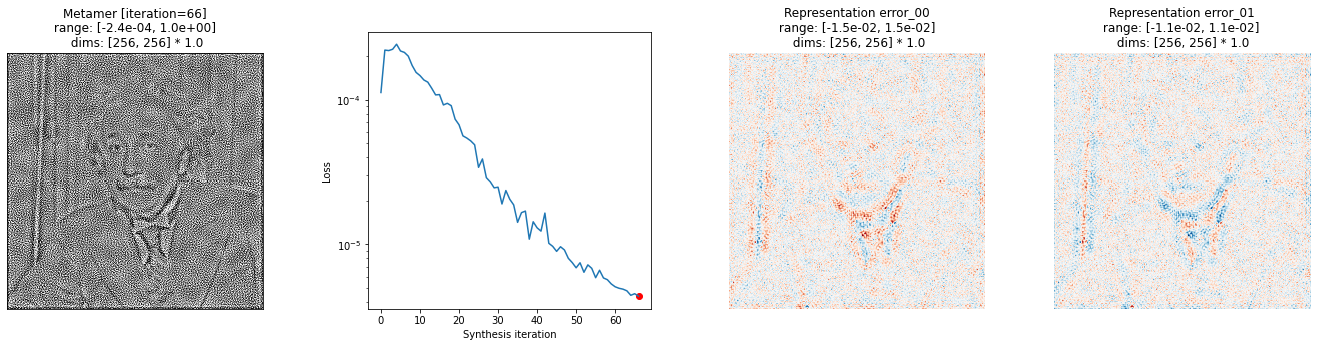

In [13]:
# we have two image plots for representation error, so that bit should be 2x wider
fig = po.synth.metamer.plot_synthesis_status(
    met, width_ratios={"plot_representation_error": 2.1}
)

You can also create this plot at different iterations, in order to try and better understand what's happening

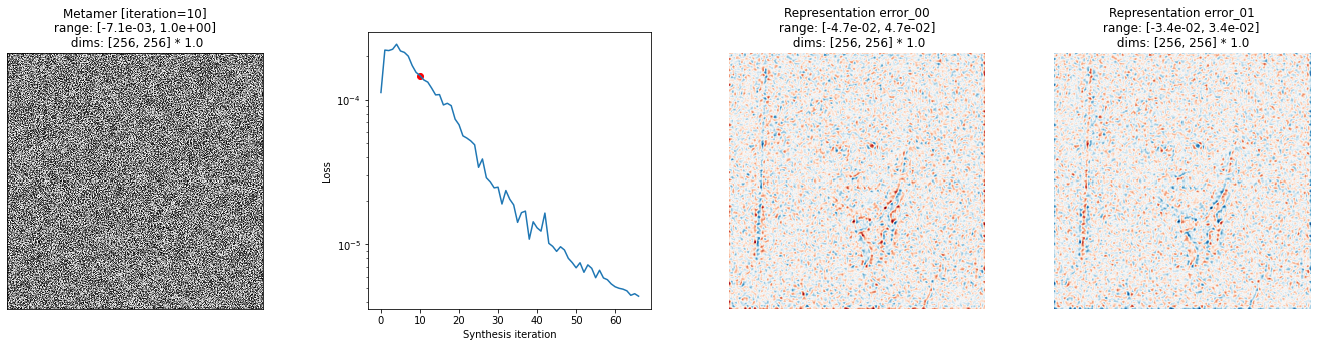

In [14]:
fig = po.synth.metamer.plot_synthesis_status(
    met, iteration=10, width_ratios={"plot_representation_error": 2.1}
)

The appearance of this figure is very customizable. There are several additional plots that can be included, and all plots are optional. The additional plot below is two histograms comparing the pixel values of the synthesized and base signal.

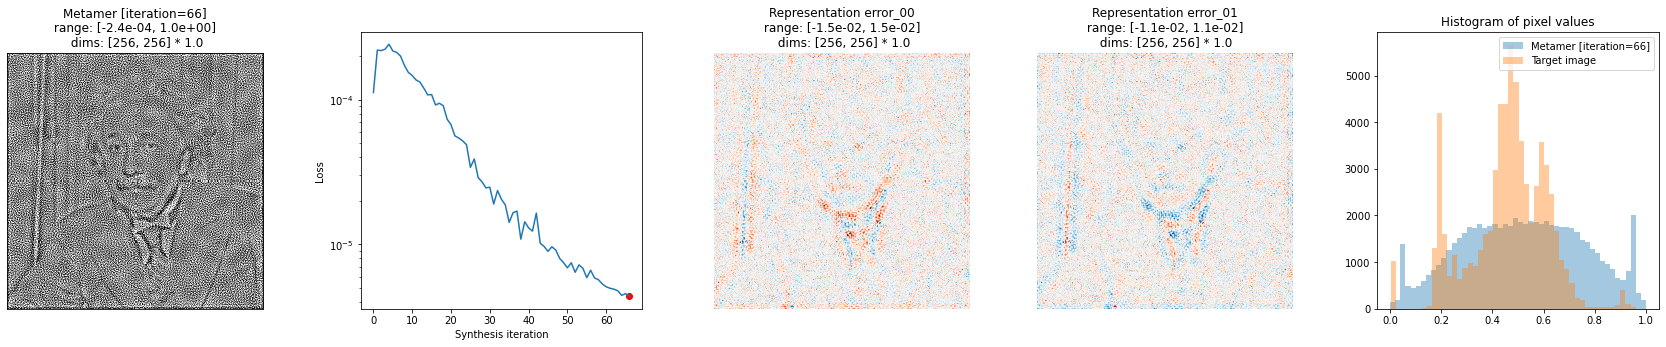

In [15]:
fig = po.synth.metamer.plot_synthesis_status(
    met,
    included_plots=[
        "display_metamer",
        "plot_loss",
        "plot_representation_error",
        "plot_pixel_values",
    ],
    width_ratios={"plot_representation_error": 2.1},
)

In addition to being able to customize which plots to include, you can also pre-create the figure (with axes, if you'd like) and pass it in. By default, we try and create an appropriate-looking figure, with appropriately-sized plots, but this allows for more flexibility:

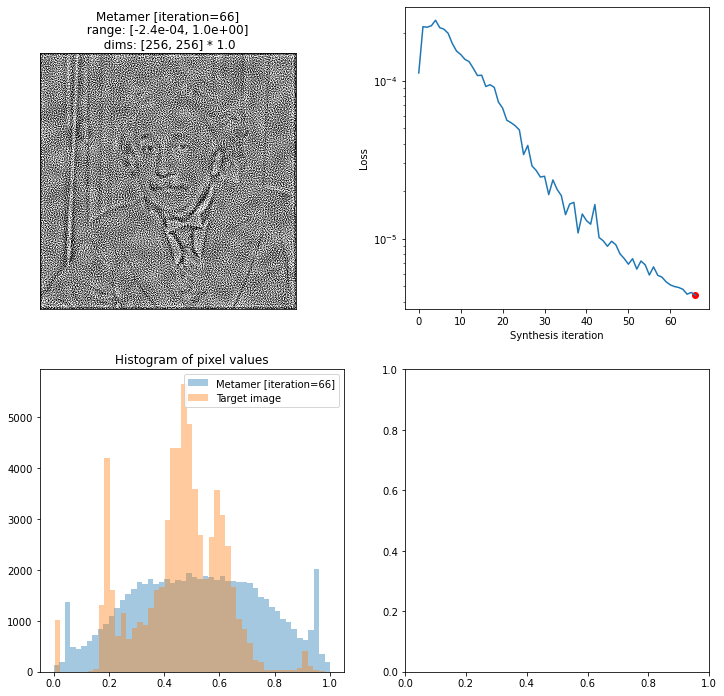

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig = po.synth.metamer.plot_synthesis_status(
    met,
    included_plots=["display_metamer", "plot_loss", "plot_pixel_values"],
    fig=fig,
)

For even more flexibility, you can specify which plot should go in which axes, by creating an `axes_idx` dictionary. Keys for each plot can be created, as well as a subset (in which case each plot gets added to the next available axes, like above when `axes_idx` is unset; see docstring for key names):

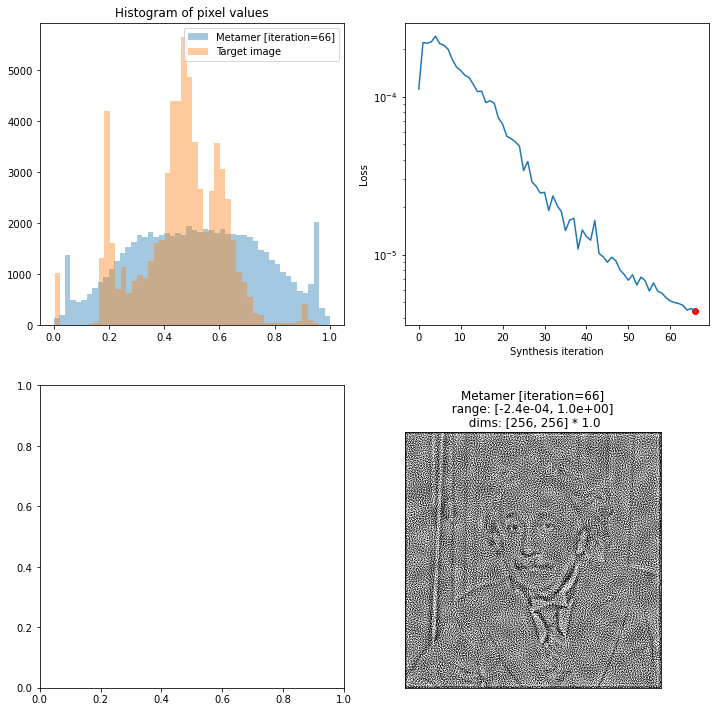

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes_idx = {"display_metamer": 3, "plot_pixel_values": 0}
fig = po.synth.metamer.plot_synthesis_status(
    met,
    included_plots=["display_metamer", "plot_loss", "plot_pixel_values"],
    fig=fig,
    axes_idx=axes_idx,
)

This allows enables you to create more complicated figures, with axes containing other plots, arrows and other annotations, etc.

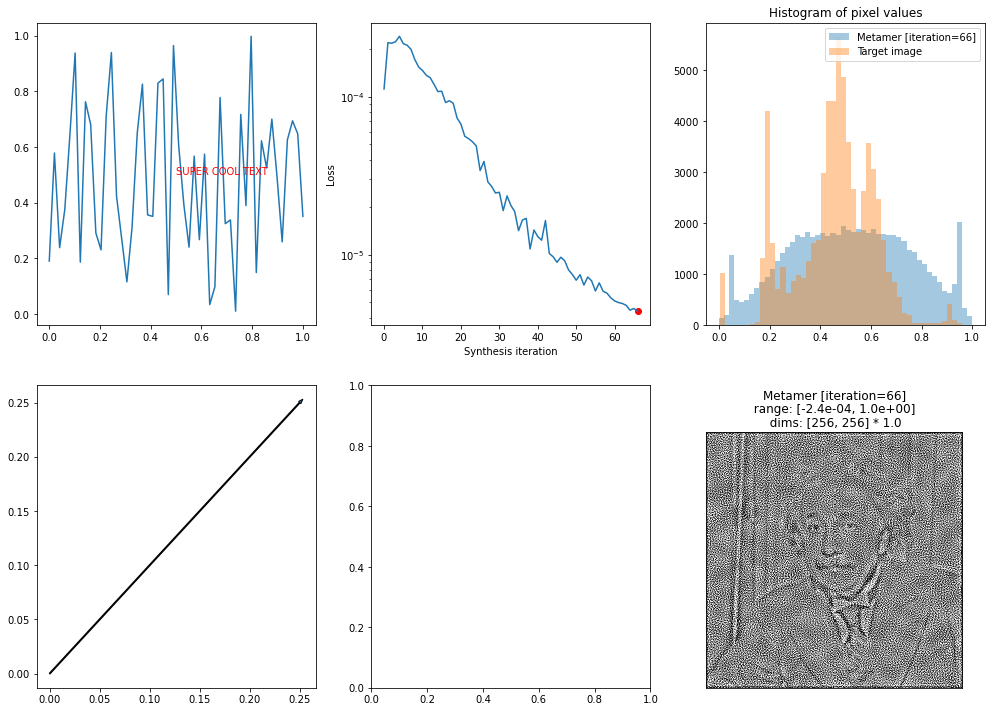

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(17, 12))
# to tell plot_synthesis_status to ignore plots, add them to the misc keys
axes_idx = {"display_metamer": 5, "misc": [0, 4]}
axes[0, 0].text(0.5, 0.5, "SUPER COOL TEXT", color="r")
axes[1, 0].arrow(
    0,
    0,
    0.25,
    0.25,
)
axes[0, 0].plot(np.linspace(0, 1), np.random.rand(50))
fig = po.synth.metamer.plot_synthesis_status(
    met,
    included_plots=["display_metamer", "plot_loss", "plot_pixel_values"],
    fig=fig,
    axes_idx=axes_idx,
)

We similarly have an {func}`animate <plenoptic.synthesize.metamer.animate>` function, which animates the above plots over time, and everything that I said above also holds for them. Note that {func}`animate <plenoptic.synthesize.metamer.animate>` will take a fair amount of time to run and requires [ffmpeg](https://ffmpeg.org/download.html) on your system for most file formats (see [matplotlib docs](https://matplotlib.org/stable/api/animation_api.html#writer-classes) for more details).

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(17, 12))
# to tell plot_synthesis_status to ignore plots, add them to the misc keys
axes_idx = {"display_metamer": 5, "misc": [0, 4]}
axes[0, 0].text(0.5, 0.5, "SUPER COOL TEXT", color="r")
axes[1, 0].arrow(
    0,
    0,
    0.25,
    0.25,
)
axes[0, 0].plot(np.linspace(0, 1), np.random.rand(50))
po.synth.metamer.animate(
    met,
    included_plots=["display_metamer", "plot_loss", "plot_pixel_values"],
    fig=fig,
    axes_idx=axes_idx,
)

## More complicated model representation plots

While this provides a starting point, it's not always super useful. In the example above, the {class}`LinearNonlinear <plenoptic.simulate.models.frontend.LinearNonlinear>` model returns the output of several convolutional kernels across the image, and so plotting as a series of images is pretty decent. The representation of the {class}`PortillaSimoncelli <plenoptic.simulate.models.PortillaSimoncelli>` model below, however, has several distinct components at multiple spatial scales and orientations. That structure is lost in a single stem plot:

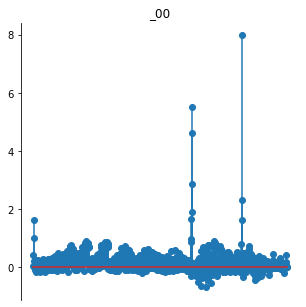

In [20]:
img = po.data.reptile_skin().to(DEVICE)
ps = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
rep = ps(img)
po.tools.display.plot_representation(data=rep);

Trying to guess this advanced structure would be impossible for our generic plotting functions. However, if your model has a `plot_representation` <!-- skip-lint --> method, we can make use of it:

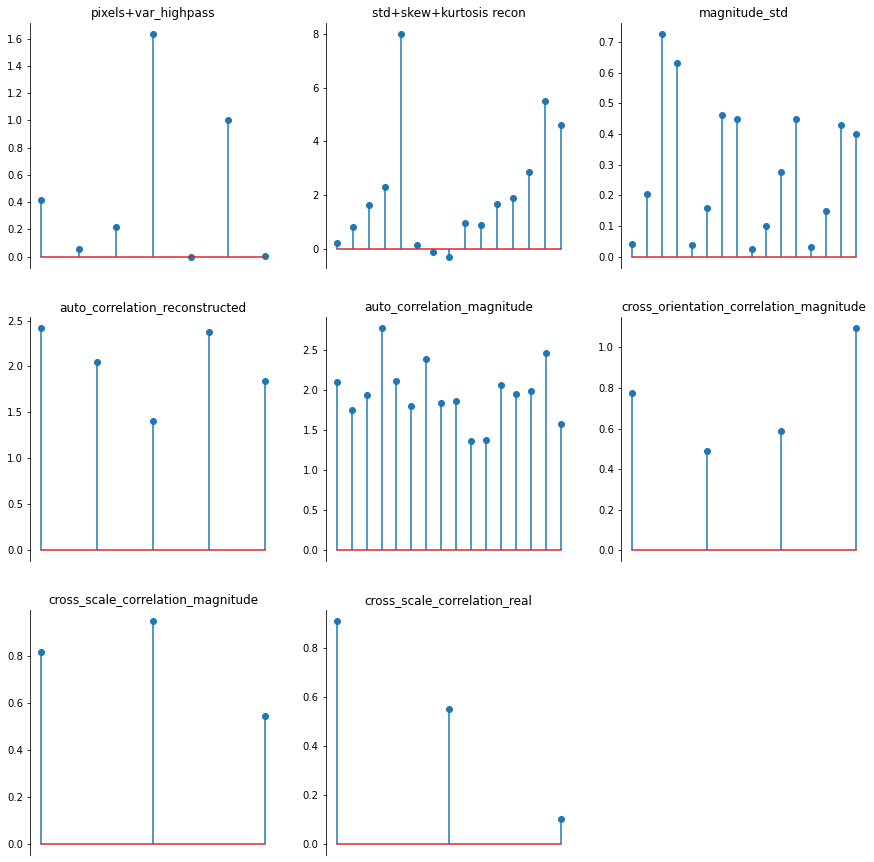

In [21]:
ps.plot_representation(data=rep, ylim=False);

Our {func}`plot_representation <plenoptic.tools.display.plot_representation>` function can make use of this method if you pass it the model; note how the plot below is identical to the one above. This might not seem very useful, but we make use of this in the different plotting methods used by our synthesis classes explained above.

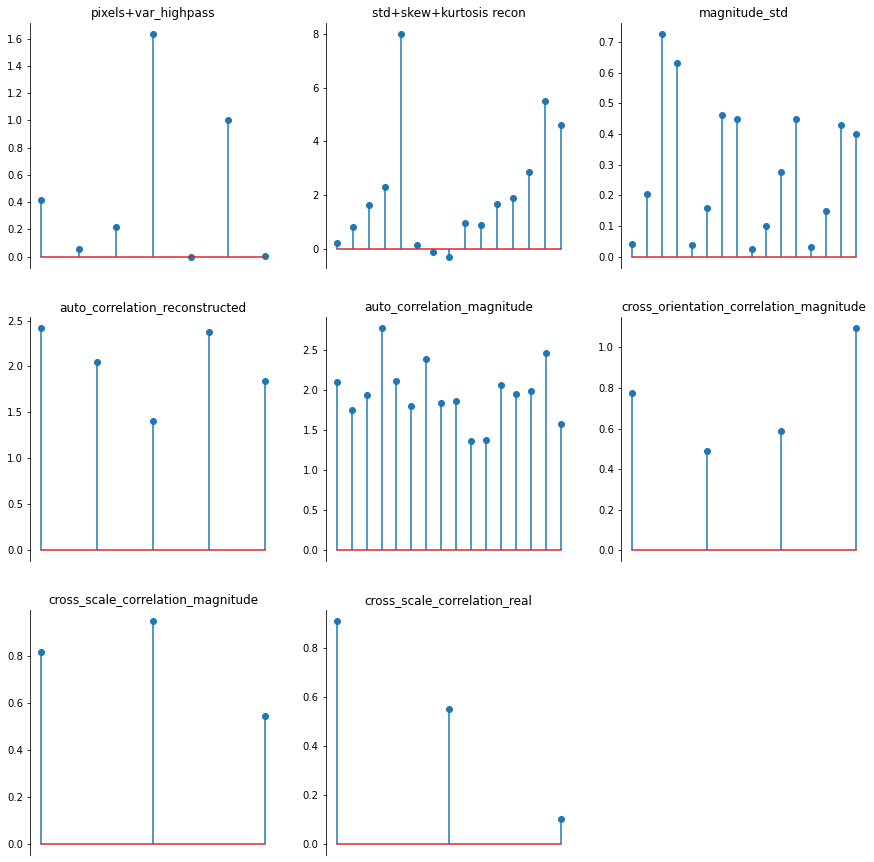

In [22]:
po.tools.display.plot_representation(ps, rep, figsize=(15, 15));

In [23]:
met = po.synth.MetamerCTF(
    img, ps, loss_function=po.tools.optim.l2_norm, coarse_to_fine="together"
)
met.synthesize(
    max_iter=400,
    store_progress=10,
    change_scale_criterion=None,
    ctf_iters_to_check=10,
);

/mnt/home/wbroderick/plenoptic-clean/src/plenoptic/tools/validate.py:343: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

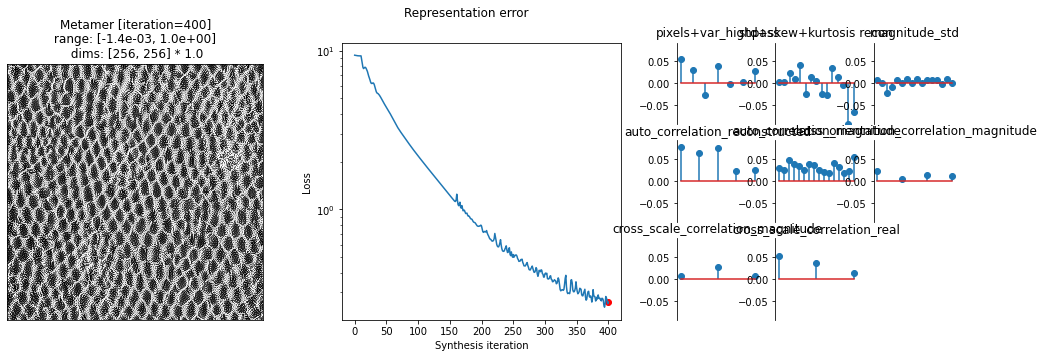

In [24]:
fig, _ = po.synth.metamer.plot_synthesis_status(met)

And again, we can animate this over time:

In [25]:
po.synth.metamer.animate(met)